In [ ]:
# !pip install tensorflow-datasets
!pip install -U tfds-nightly
# !pip install tensorflow-gpu

In [ ]:
# print(tf.__version__)
# !pip install tensorflow==2.* --user

In [ ]:
# !pip install -U --pre tensorflow=="2.1"
!pip install tf_slim

In [ ]:
!pip install pycocotools

In [ ]:
# !pip install tensorflow==2.1
# !pip install six

In [ ]:
import numpy as np
import os
import six
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
# import tensorflow.compat.v1 as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display



In [ ]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%%bash 
cd models/research
pip install .

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
import tensorflow_datasets as tfds


In [ ]:
# ds = tfds.load('kitti', split='train',data_dir='/content/tensorflow_datasets', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
# print(ds)

In [ ]:
# !gcloud auth login application-default



In [ ]:
!gcloud config set account application-default

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# !gcloud auth login dissertation-0




In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
#     shuffle_files=True,
    # as_supervised=True,
#     try_gcs=True,
    with_info=True,
    download=False,
#     data_dir='./tensorflow_datasets'
    data_dir="gs://kitti-dataset-1"
)

# ds = tfds.load('kitti', split='train',data_dir='/content/tensorflow_datasets')


In [ ]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [ ]:

# model_name = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'
# model_name = 'ssd_inception_v2_coco_2018_01_28'
model_name = 'faster_rcnn_resnet50_lowproposals_coco_2018_01_28'
# model_name = 'faster_rcnn_resnet101_kitti_2018_01_28'
# model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
# model_name = 'faster_rcnn_nas_lowproposals_coco_2018_01_28'
detection_model = load_model(model_name)


In [ ]:
# List of the strings that is used to add correct label for each box.

# PATH_TO_LABELS = 'models/research/object_detection/data/kitti_label_map.pbtxt'
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


In [ ]:
# ds_train =ds 

In [ ]:
def normalize_img(object):
  print(object['objects'])
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(object['image'], tf.float32) / 255., object['objects']['bbox']



In [ ]:
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_train

In [ ]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(detection_model.inputs)



In [ ]:
detection_model.output_dtypes

In [ ]:
detection_model.output_shapes

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
def norm(data):
    height= 375
    width = 1242
    
    data['xmin'] = data['xmin'] / width 
    data['xmax'] = data['xmax'] / width
    data['ymin'] = (height - data['ymin']) / height
    data['ymax'] = (height - data['ymax']) / height
    
    return data

In [ ]:
import pandas as pd
import numpy as np
import time

# import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from tqdm.keras import TqdmCallback



# ----------- import data and scaling ----------- #
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

X_train = df_train[['xmin', 'xmax', 'ymin' ,'ymax']]
y_train = df_train[['xloc', 'yloc','zloc']].values

X_test = df_test[['xmin', 'xmax', 'ymin','ymax']].values
y_test = df_test[['xloc', 'yloc','zloc']].values

#  ymin=(height - bbox.bottom) / height,
#       ymax=(height - bbox.top) / height,
#       xmin=bbox.left / width,
#       xmax=bbox.right / width,
# 375 ,1242
# standardized data
# xScalar = StandardScaler()
# yScalar = StandardScaler()
# X_train = xScalar.fit_transform(X_train)
# y_train = yScalar.fit_transform(y_train)

X_train = norm(X_train).values

In [ ]:
# X_train = df_train[['xmin', 'xmax', 'ymin' ,'ymax']].values

print(X_train[:10])

# X_train = norm(X_train)
# X_train[:10]


In [ ]:
# TRAINING MODE


# ----------- create model ----------- #
model = keras.Sequential()
model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(150, kernel_initializer='normal', activation='relu'))
model.add(Dense(150, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal'))


# opt = tf.keras.optimizers.Adam(
#     learning_rate=0.001
# )
# model = multi_gpu_model(model, gpus=2)
model.compile(loss='mean_squared_error',optimizer='adam')

# ----------- define callbacks ----------- #
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7,
                verbose=1, min_delta=1e-4, mode='min')
modelname = "model@{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir="logs/{}".format(modelname))

# ----------- start training ----------- #
history = model.fit(X_train, y_train,
            validation_split=0.1, epochs=10000, batch_size=8000,verbose=0, callbacks=[tensorboard, TqdmCallback(verbose=1)])


# ----------- save model and weights ----------- #
model_json = model.to_json()
with open("generated_files/{}.json".format(modelname), "w") as json_file:
   json_file.write(model_json)

model.save_weights("generated_files/{}.h5".format(modelname))
print("Saved model to disk")



In [ ]:
pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


In [ ]:
plotter.plot({'Basic': history}, metric = "loss")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
# INFERENCE MODE

from tensorflow.keras.models import model_from_json

df_test = pd.read_csv('data/test.csv')
X_test = df_test[['xmin', 'xmax', 'ymin','ymax']]
y_test = df_test[['xloc' ,'yloc','zloc']].values

# standardized data
# scalar = MinMaxScaler()
# X_test = scalar.fit_transform(X_test)
# y_test = yScalar.fit_transform(y_test)
    
X_test = norm(X_test).values
print(X_test[:10])

# MODEL = "model@1595813111"
# WEIGHTS = "model@1595813111"

MODEL = modelname
WEIGHTS = modelname


# load json and create model
json_file = open('generated_files/{}.json'.format(MODEL), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json( loaded_model_json )

# load weights into new model
loaded_model.load_weights("generated_files/{}.h5".format(WEIGHTS))
print("Loaded model from disk")

# loaded_model = model
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
y_pred = loaded_model.predict(X_test)


# scale up predictions to original values
# y_pred_transformed = yScalar.inverse_transform(y_pred)
# y_test_transformed = yScalar.inverse_transform(y_test)

# y_pred_transformed = y_pred
# save predictions
df_result = df_test
df_result['zloc_pred'] = -100000
df_result['xloc_pred'] = -100000


for idx, row in df_result.iterrows():
    df_result.at[idx, 'zloc_pred'] = y_pred[idx][2]
    df_result.at[idx, 'xloc_pred'] = y_pred[idx][0]

df_result.to_csv('data/predictions2.csv', index=False)

In [ ]:

def run_locnet( bboxes):
  
    print( bboxes)
#     bboxes = xScalar.transform(bboxes)
    y_pred = loaded_model.predict(bboxes)
    # scale up predictions to original values
#     y_pred_transformed = yScalar.inverse_transform(y_pred)

    return y_pred
#     return y_pred_transformed

In [ ]:
def transform_to_kitti(classes):
    
    print('classes', classes)
    hash = { 3:0 , 8:2, 1:3, 7:6 }
    return [ hash.get(classes[i], 7) for i in range(len(classes)) ]

In [122]:
def filter_detections( output_dict):
    
    output_dict['detection_classes'] = transform_to_kitti(output_dict['detection_classes'])
    

    output_dict['detection_boxes'] = np.array([ output_dict['detection_boxes'][i] for i in range(len(output_dict['detection_boxes'])) if output_dict['detection_scores'][i] > 0.5 and output_dict['detection_classes'][i] not in (7,8)  ])
    output_dict['detection_classes'] = np.array([ output_dict['detection_classes'][i] for i in range(len(output_dict['detection_boxes'])) if output_dict['detection_scores'][i] > 0.5 and output_dict['detection_classes'][i] not in (7,8)  ])

    print('aaa',output_dict['detection_classes'])
    return output_dict

In [ ]:
def process_image(image):
  

    image_np = np.copy(image) #TODO: make more efficent 
    
    output_dict = run_inference_for_single_image(detection_model, image_np)
    # Visualization of the results of a detection.
#     print(output_dict)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=1)
    
#     print("output_dict_before:" ,output_dict)

    output_dict =filter_detections( output_dict)
#     print("output_dict" ,output_dict)
    locations = run_locnet( output_dict['detection_boxes'])
    
 
    
    print( "distance_vector")

    print( locations)
#     vis_util.draw_bounding_box_on_image_array(image_np, xmin, ymin, xmax, ymax, thickness=1, display_str_list=[distance])
    
    return image_np

In [ ]:
run_locnet( [[0.41085333,0.4335749 ,0.5223467 ,0.4712963 ]])

In [ ]:

# Load the TensorBoard notebook extension
# %reload_ext tensorboard


%tensorboard --logdir logs


In [ ]:
%reload_ext tensorboard

In [ ]:
!pip install tensorboard 

In [ ]:
def show_inference(model, tensor):
  
  
    image_np = np.array(tensor)
    image =process_image(image_np)
    display(Image.fromarray(image))
    return

In [ ]:
# df = tfds.as_dataframe(ds_train.take(10), ds_info)

In [ ]:
# df

In [ ]:
ds_numpy = tfds.as_numpy(ds_train.take(10))

In [ ]:
for ex in ds_numpy:
  # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
  print(ex)

In [ ]:
for example in ds_test.take(10):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    objects = example["objects"]
  
    print( image.shape)
    print(objects['bbox'])
    print('location:', objects['location'])
    print('type:', objects['type'])
    show_inference(detection_model, image)




In [ ]:
ds_info

In [ ]:
#Evaluation Steps


from object_detection import eval_util
from object_detection.core import standard_fields as fields
from object_detection.metrics import coco_evaluation
from object_detection.protos import eval_pb2
from object_detection.utils import test_case
from object_detection.utils import tf_version

def test_get_eval_metric_ops_for_coco_detections(eval_dict, batch_size=1,
                                               max_gt_boxes=None,
                                               scale_to_absolute=False):
    eval_config = eval_pb2.EvalConfig()
#     eval_config.metrics_set.extend(['pascal_voc_detection_metrics'])
    eval_config.metrics_set.extend(['coco_detection_metrics'])

    categories = list(category_index.values())

    metric_ops = eval_util.get_eval_metric_ops_for_evaluators(
        eval_config, categories, eval_dict)
    _, update_op = metric_ops['DetectionBoxes_Precision/mAP']

    with tf.compat.v1.Session() as sess:
        metrics = {}
        for key, (value_op, _) in six.iteritems(metric_ops):
            metrics[key] = value_op
        sess.run(update_op)
        metrics = sess.run(metrics)
        print(metrics)
        
  
# def test_get_estimator_eval_metric_ops(eval_dict,
#                                      batch_size=1,
#                                      expected_map=1,
#                                      max_gt_boxes=None,
#                                      scale_to_absolute=False):

# #     tf.logging.info('eval_dict: {}'.format(eval_dict))
#     metric_ops = vis_util.get_estimator_eval_metric_ops(eval_dict)
#     _, update_op = metric_ops['Precision/mAP@0.5IOU']

#     with test_session() as sess:
#       metrics = {}
#       for key, (value_op, _) in six.iteritems(metric_ops):
#         metrics[key] = value_op
#       sess.run(update_op)
#       metrics = sess.run(metrics)

In [ ]:
def result_dict_for_single_example(image,
                                   key,
                                   detections,
                                   groundtruth=None,
                                   class_agnostic=False,
                                   scale_to_absolute=False):
  """Merges all detection and groundtruth information for a single example.

  Note that evaluation tools require classes that are 1-indexed, and so this
  function performs the offset. If `class_agnostic` is True, all output classes
  have label 1.

  Args:
    image: A single 4D uint8 image tensor of shape [1, H, W, C].
    key: A single string tensor identifying the image.
    detections: A dictionary of detections, returned from
      DetectionModel.postprocess().
    groundtruth: (Optional) Dictionary of groundtruth items, with fields:
      'groundtruth_boxes': [num_boxes, 4] float32 tensor of boxes, in
        normalized coordinates.
      'groundtruth_classes': [num_boxes] int64 tensor of 1-indexed classes.
      'groundtruth_area': [num_boxes] float32 tensor of bbox area. (Optional)
      'groundtruth_is_crowd': [num_boxes] int64 tensor. (Optional)
      'groundtruth_difficult': [num_boxes] int64 tensor. (Optional)
      'groundtruth_group_of': [num_boxes] int64 tensor. (Optional)
      'groundtruth_instance_masks': 3D int64 tensor of instance masks
        (Optional).
      'groundtruth_keypoints': [num_boxes, num_keypoints, 2] float32 tensor with
        keypoints (Optional).
    class_agnostic: Boolean indicating whether the detections are class-agnostic
      (i.e. binary). Default False.
    scale_to_absolute: Boolean indicating whether boxes and keypoints should be
      scaled to absolute coordinates. Note that for IoU based evaluations, it
      does not matter whether boxes are expressed in absolute or relative
      coordinates. Default False.

  Returns:
    A dictionary with:
    'original_image': A [1, H, W, C] uint8 image tensor.
    'key': A string tensor with image identifier.
    'detection_boxes': [max_detections, 4] float32 tensor of boxes, in
      normalized or absolute coordinates, depending on the value of
      `scale_to_absolute`.
    'detection_scores': [max_detections] float32 tensor of scores.
    'detection_classes': [max_detections] int64 tensor of 1-indexed classes.
    'detection_masks': [max_detections, H, W] float32 tensor of binarized
      masks, reframed to full image masks.
    'groundtruth_boxes': [num_boxes, 4] float32 tensor of boxes, in
      normalized or absolute coordinates, depending on the value of
      `scale_to_absolute`. (Optional)
    'groundtruth_classes': [num_boxes] int64 tensor of 1-indexed classes.
      (Optional)
    'groundtruth_area': [num_boxes] float32 tensor of bbox area. (Optional)
    'groundtruth_is_crowd': [num_boxes] int64 tensor. (Optional)
    'groundtruth_difficult': [num_boxes] int64 tensor. (Optional)
    'groundtruth_group_of': [num_boxes] int64 tensor. (Optional)
    'groundtruth_instance_masks': 3D int64 tensor of instance masks
      (Optional).
    'groundtruth_keypoints': [num_boxes, num_keypoints, 2] float32 tensor with
      keypoints (Optional).
  """

  if groundtruth:
    max_gt_boxes = tf.shape(
        groundtruth[fields.InputDataFields.groundtruth_boxes])[0]
    for gt_key in groundtruth:
      # expand groundtruth dict along the batch dimension.
      groundtruth[gt_key] = tf.expand_dims(groundtruth[gt_key], 0)

  for detection_key in detections:
    detections[detection_key] = tf.expand_dims(
        detections[detection_key][0], axis=0)

  batched_output_dict = eval_util.result_dict_for_batched_example(
      image,
      tf.expand_dims(key, 0),
      detections,
      groundtruth,
      class_agnostic,
      scale_to_absolute,
      max_gt_boxes=max_gt_boxes)


  return batched_output_dict

classes [ 3 64  7  3 64]
aaa [0]
[[0.48387626 0.43768257 0.58862966 0.47398788]]
distance_vector
[[ 0.30016923 -0.12836611 -0.7122133 ]]


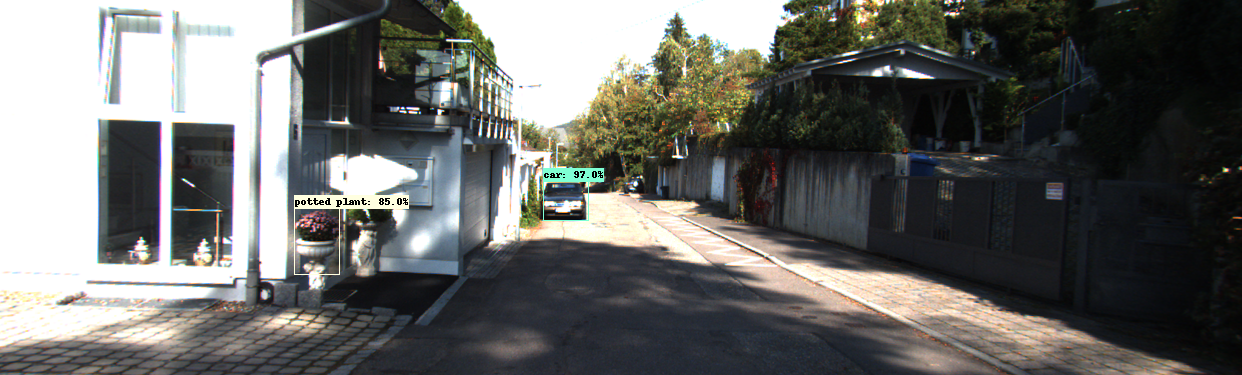

classes [ 3 64  7  3 64]
aaa [0]
(1, 375, 1242, 3)
INFO:tensorflow:Performing evaluation on 1 images.


INFO:tensorflow:Performing evaluation on 1 images.


creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...


INFO:tensorflow:Loading and preparing annotation results...


INFO:tensorflow:DONE (t=0.00s)


INFO:tensorflow:DONE (t=0.00s)


creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.

TypeError: Fetch argument None has invalid type <class 'NoneType'>

In [123]:
#TODO: Complete Evaluation steps
input_data_fields = fields.InputDataFields
detection_fields = fields.DetectionResultFields

for example in ds_test.take(1):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
#     print(list(example.keys()))
    image = example["image"]
    objects = example["objects"]
  
#     print( objects)
#     print(objects['location'])
    show_inference(detection_model, image)
    image_np = np.array(image)
    # Actual detection.
    output_dict = run_inference_for_single_image(detection_model, image_np)
    
#       return eval_util.result_dict_for_single_example(
#           image, key, detections, groundtruth,
#           scale_to_absolute=scale_to_absolute)

    output_dict = filter_detections( output_dict)
#     batch_size = 100
#     key = tf.constant([str(i) for i in range(batch_size)])
    batch_size = 1
    key=tf.constant('image1')
#     key = tf.constant([str(i) for i in range(batch_size)])
    
    groundtruth_boxes = objects['bbox']
    groundtruth_classes = objects['type']+1
#     groundtruth_is_difficult_list = tf.constant( [[[False]* len(objects['bbox'])]])
    groundtruth = {
        input_data_fields.groundtruth_boxes: groundtruth_boxes,
        input_data_fields.groundtruth_classes: groundtruth_classes,
#         input_data_fields.groundtruth_difficult: groundtruth_is_difficult_list
      
    }
    
    num_detections = tf.constant([len(output_dict['detection_classes'])])
    
#     num_detections = tf.ones([batch_size])
    detections = {
        detection_fields.detection_boxes: tf.tile(tf.constant([output_dict['detection_boxes']]), multiples=[batch_size, 1 ,1]) ,
        detection_fields.detection_scores: tf.tile(tf.constant([output_dict['detection_scores']]), multiples=[batch_size, 1]) ,
        detection_fields.detection_classes: tf.tile(tf.constant([output_dict['detection_classes']]), multiples=[batch_size, 1]) ,
        detection_fields.num_detections: num_detections
       
    }
    
#     print(detections)

    image = tf.constant([image_np])
    print(image.shape)
 

    result_dict = result_dict_for_single_example(image, key,detections, groundtruth)
    
    categories = list(category_index.values())
    
#     result_dict2 = {k: v.numpy() for k, v in result_dict.items()}
#     eval_util.visualize_detection_results(result_dict2,'tag',10,categories)

    test_get_eval_metric_ops_for_coco_detections(result_dict)
#     test_get_estimator_eval_metric_ops(result_dict)

In [124]:
result_dict

{'original_image': <tf.Tensor: shape=(1, 375, 1242, 3), dtype=int32, numpy=
 array([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [  8,  12,  10],
          [  8,  11,  10],
          [  7,  10,  10]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [  8,  12,  10],
          [  7,  11,  10],
          [  6,  10,  10]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [  8,  13,  11],
          [  7,  11,  10],
          [  7,   9,  10]],
 
         ...,
 
         [[ 71,  58,  50],
          [ 74,  61,  52],
          [ 75,  69,  55],
          ...,
          [ 14,  13,  12],
          [ 14,  13,  11],
          [ 14,  13,  13]],
 
         [[ 75,  85, 101],
          [ 76,  92, 102],
          [ 75,  99, 106],
          ...,
          [ 14,  15,  17],
          [ 14,  15,  16],
          [ 14,  14,  16]],
 
        

In [ ]:
!pip install moviepy proglog

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
# !gsutil cp gs://hazard-detection-test-videos/accident_compilation.mp4 accident_compilation.mp4

In [ ]:
!ls -sh accident_compilation.mp4

In [ ]:
from moviepy.editor import VideoFileClip
import proglog
proglog.notebook()

write_output = 'output_' + model_name + '.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first n seconds
# clip1 = VideoFileClip("test.mp4").subclip(0,1)

# clip1 = VideoFileClip("test.mp4")

clip1 = VideoFileClip("accident_compilation.mp4")


white_clip = clip1.fl_image(process_image) 

white_clip.write_videofile(write_output, audio=False, verbose=False)

clip1.close()


In [ ]:
# import os
# os.environ['PYTHONPATH'] += ":/content/models"

# import sys
# sys.path.append("/content/models")

!pip install tf-models-official --user

In [ ]:
# !python models/research/object_detection/legacy/eval.py --pipeline_config_path=gs://hazard-detection-test-videos/job_dir/pipeline.config  --checkpoint_dir=gs://hazard-detection-test-videos/job_dir --eval_dir=gs://hazard-detection-test-videos/eval_dir

In [ ]:
!python models/research/object_detection/model_main.py --pipeline_config_path=pipeline.config  --checkpoint_dir=checkpoint_dir --model_dir=eval_dir
            
            
            
            
            

In [ ]:
# !gsutil cp gs://hazard-detection-test-videos/tf2model/* ./

In [ ]:
!ls checkpoint_dir

## LocNet starts
